In [64]:
import os
import cv2
from deepface import DeepFace
import numpy as np
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import pandas as pd




In [65]:
INPUT_DIR = Path("../data/crops_face/20251107/3_cafe_pos_frontal_faces")
OUTPUT_DIR = Path("../data/crops_face/20251107/4_cafe_pos_cluster_faces")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [66]:
image_paths = sorted(p for p in INPUT_DIR.glob("*.png"))

In [67]:
"""
──────────────────────────────────────────────────────────────
NOTE: DeepFace Embedding Models and Detector Backends
──────────────────────────────────────────────────────────────

DeepFace provides multiple model and detector options for 
face embedding and analysis, each with distinct trade-offs.

EMBEDDING MODELS:
- VGG-Face: classic, heavy, robust on clean data.
- Facenet / Facenet512: balanced accuracy and speed (recommended).
- ArcFace: state-of-the-art accuracy, robust to lighting/angles.
- SFace: modern lightweight model for CCTV and real-time use.
- Dlib / OpenFace: small, fast, less precise.
- DeepID / DeepFace (Facebook): early academic baselines.

FACE DETECTOR BACKENDS:
- yunet: very fast OpenCV-based detector (recommended default).
- retinaface: highest accuracy, robust to occlusions (slower).
- mtcnn: precise but slower, good for small datasets.
- opencv / dlib: lightweight, CPU-only, moderate accuracy.
- mediapipe / centerface: good alternatives for real-time or mobile.

For this project:
✅ Model: Facenet512  → best balance between speed & consistency
✅ Detector: Yunet   → efficient for batch embedding and CCTV footage
──────────────────────────────────────────────────────────────
"""

'\n──────────────────────────────────────────────────────────────\nNOTE: DeepFace Embedding Models and Detector Backends\n──────────────────────────────────────────────────────────────\n\nDeepFace provides multiple model and detector options for \nface embedding and analysis, each with distinct trade-offs.\n\nEMBEDDING MODELS:\n- VGG-Face: classic, heavy, robust on clean data.\n- Facenet / Facenet512: balanced accuracy and speed (recommended).\n- ArcFace: state-of-the-art accuracy, robust to lighting/angles.\n- SFace: modern lightweight model for CCTV and real-time use.\n- Dlib / OpenFace: small, fast, less precise.\n- DeepID / DeepFace (Facebook): early academic baselines.\n\nFACE DETECTOR BACKENDS:\n- yunet: very fast OpenCV-based detector (recommended default).\n- retinaface: highest accuracy, robust to occlusions (slower).\n- mtcnn: precise but slower, good for small datasets.\n- opencv / dlib: lightweight, CPU-only, moderate accuracy.\n- mediapipe / centerface: good alternatives f

In [68]:
embeddings = []  # keep your list defined above

for img_path in tqdm(image_paths):
    try:
        embeddings_obj = DeepFace.represent(
            img_path=str(img_path),
            model_name="Facenet512",
            detector_backend="yunet",
            enforce_detection=True
        )

        # ✅ Save embedding data
        embeddings.append({
            "file": img_path.name,
            "embedding": embeddings_obj[0]["embedding"]
        })

    except Exception as e:
        #print(f"⚠️ Skipped {img_path.name} due to error: {e}")
        continue

100%|██████████| 5732/5732 [31:20<00:00,  3.05it/s]


In [69]:
# Example: assemble into DataFrame from your loop memory
df = pd.DataFrame(embeddings)
print(f"✅ Total embeddings: {len(df)}")
df.head()

✅ Total embeddings: 5550


,file,embedding
0,AccoID_1170787_20251107_083424.png,"[0.5659781694412231, 0.10609972476959229, 0.21..."
1,AccoID_1170787_20251107_083425.png,"[1.4070382118225098, 0.2582961916923523, -0.72..."
2,AccoID_1170787_20251107_083426.png,"[0.5026126503944397, 0.0571352057158947, 0.564..."
3,AccoID_1170787_20251107_083427.png,"[0.7198768258094788, 0.39554110169410706, 0.92..."
4,AccoID_1170787_20251107_083428.png,"[0.41626811027526855, 0.035023026168346405, -0..."


In [70]:
df.to_pickle("../data/crops_face/20251107/4_facial_embeddings/cafe_pos_embeddings.pkl")
df.head()

,file,embedding
0,AccoID_1170787_20251107_083424.png,"[0.5659781694412231, 0.10609972476959229, 0.21..."
1,AccoID_1170787_20251107_083425.png,"[1.4070382118225098, 0.2582961916923523, -0.72..."
2,AccoID_1170787_20251107_083426.png,"[0.5026126503944397, 0.0571352057158947, 0.564..."
3,AccoID_1170787_20251107_083427.png,"[0.7198768258094788, 0.39554110169410706, 0.92..."
4,AccoID_1170787_20251107_083428.png,"[0.41626811027526855, 0.035023026168346405, -0..."


In [71]:
lengths = df["embedding"].apply(len)
print(f"Vector length consistency: {lengths.unique()}")

Vector length consistency: [512]


In [72]:
print(df["embedding"].iloc[0][:10])

[0.5659781694412231, 0.10609972476959229, 0.21223270893096924, 1.7492470741271973, 2.2595109939575195, 1.095583438873291, -0.41212159395217896, 0.2645726203918457, -1.1048027276992798, -0.7058473825454712]


In [73]:
sample_df = df.sample(min(10,len(df)),random_state=42)
X= np.vstack(sample_df["embedding"].values)

sim_matrix = cosine_similarity(X)

pd.DataFrame(np.round(sim_matrix,3), index=sample_df["file"].values, columns=sample_df["file"].values)

,AccoID_1171137_20251107_104758.png,AccoID_1171810_20251107_143644.png,AccoID_1171607_20251107_133939.png,AccoID_1170866_20251107_091610.png,AccoID_1171426_20251107_123632.png,AccoID_1171765_20251107_142349.png,AccoID_1170989_20251107_095510.png,AccoID_1171144_20251107_104814.png,AccoID_1171678_20251107_140109.png,AccoID_1170887_20251107_091709.png
AccoID_1171137_20251107_104758.png,1.000,0.030,-0.040,0.178,0.131,0.233,-0.030,0.665,0.118,-0.059
AccoID_1171810_20251107_143644.png,0.030,1.000,0.040,0.247,0.170,0.114,0.128,0.042,0.006,-0.116
AccoID_1171607_20251107_133939.png,-0.040,0.040,1.000,0.055,0.026,0.118,0.273,-0.038,0.193,0.139
AccoID_1170866_20251107_091610.png,0.178,0.247,0.055,1.000,0.238,0.082,-0.059,0.158,0.094,-0.247
AccoID_1171426_20251107_123632.png,0.131,0.170,0.026,0.238,1.000,0.053,0.153,0.202,0.322,0.074
AccoID_1171765_20251107_142349.png,0.233,0.114,0.118,0.082,0.053,1.000,-0.032,-0.001,0.040,0.178
AccoID_1170989_20251107_095510.png,-0.030,0.128,0.273,-0.059,0.153,-0.032,1.000,0.071,0.037,0.186
AccoID_1171144_20251107_104814.png,0.665,0.042,-0.038,0.158,0.202,-0.001,0.071,1.000,0.155,0.029
AccoID_1171678_20251107_140109.png,0.118,0.006,0.193,0.094,0.322,0.040,0.037,0.155,1.000,0.053
AccoID_1170887_20251107_091709.png,-0.059,-0.116,0.139,-0.247,0.074,0.178,0.186,0.029,0.053,1.000


In [74]:
import hdbscan
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from pathlib import Path
from tqdm import tqdm
import shutil, os


In [75]:
import joblib

pickle_path = "../data/crops_face/20251107/4_facial_embeddings/cafe_pos_embeddings.pkl"
df = pd.read_pickle(pickle_path)

print("✅ Pickle loaded successfully!")
print(f"Rows: {len(df)}")
print("Columns:", list(df.columns))

✅ Pickle loaded successfully!
Rows: 5550
Columns: ['file', 'embedding']


In [76]:
# === Step 1: Normalize embeddings ===
X = np.vstack(df["embedding"].values)
X_norm = normalize(X)

In [77]:
from sklearn.metrics.pairwise import cosine_distances

# Compute cosine distance matrix
dist_matrix = cosine_distances(X_norm)

# Run HDBSCAN with precomputed metric
clusterer = hdbscan.HDBSCAN(
    metric='precomputed',
    min_cluster_size=6,
    min_samples=2,
    cluster_selection_epsilon=0.05,
    cluster_selection_method='leaf'
).fit(dist_matrix)

# Assign labels
df['cluster_id'] = clusterer.labels_

# Cluster summary
total_images = len(df)
n_clusters = len(set(df['cluster_id'])) - (1 if -1 in df['cluster_id'].values else 0)
noise_points = list(df['cluster_id']).count(-1)
noise_ratio = noise_points / total_images * 100
avg_cluster_size = df[df['cluster_id'] != -1]['cluster_id'].value_counts().mean()

print(f"✅ HDBSCAN Summary:")
print(f"Total images: {total_images}")
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {noise_points} ({noise_ratio:.2f}%)")
print(f"Average cluster size: {avg_cluster_size:.2f}")

✅ HDBSCAN Summary:
Total images: 5550
Clusters found: 291
Noise points: 1873 (33.75%)
Average cluster size: 12.64


In [78]:
# Distribution table
summary = (
    df["cluster_id"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "cluster_id", "cluster_id": "image_count"})
)
summary["percentage"] = (summary["image_count"] / total_images * 100).round(2)
display(summary.head(15))

,image_count,count,percentage
0,-1,1873,-0.02
1,47,93,0.85
2,107,88,1.93
3,221,66,3.98
4,46,58,0.83
5,71,56,1.28
6,272,50,4.90
7,216,48,3.89
8,120,42,2.16
9,243,42,4.38


In [79]:
# Cluster density estimation (mean intra-cluster distance)
def mean_intra_distance(X, labels):
    unique_labels = [l for l in np.unique(labels) if l != -1]
    dist = pairwise_distances(X, metric="euclidean")
    dists = []
    for label in unique_labels:
        idx = np.where(labels == label)[0]
        if len(idx) > 1:
            sub = dist[np.ix_(idx, idx)]
            mean_dist = np.mean(sub[np.triu_indices_from(sub, 1)])
            dists.append(mean_dist)
    return np.mean(dists) if dists else np.nan

intra_dist = mean_intra_distance(X_norm, df["cluster_id"])
print(f"📐 Mean intra-cluster distance: {intra_dist:.4f}")
print("──────────────────────────────")

📐 Mean intra-cluster distance: 0.4599
──────────────────────────────


In [80]:
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import hdbscan

# ============================================================
# STEP 1 — Identify noise and valid cluster points
# ============================================================
labels = df["cluster_id"].values
noise_idx = np.where(labels == -1)[0]
valid_idx = np.where(labels != -1)[0]
print(f"🧩 Noise points detected: {len(noise_idx)} ({len(noise_idx)/len(labels)*100:.2f}%)")

if len(noise_idx) > 0:
    # ============================================================
    # STEP 2 — Compute centroids for valid clusters
    # ============================================================
    centroids = []
    cluster_ids = sorted(set(labels[valid_idx]))
    for cid in cluster_ids:
        centroids.append(X_norm[labels == cid].mean(axis=0))
    centroids = np.vstack(centroids)

    # ============================================================
    # STEP 3 — Assign nearby noise points to nearest centroid
    # ============================================================
    closest, distances = pairwise_distances_argmin_min(X_norm[noise_idx], centroids, metric='cosine')

    # Threshold for accepting assignment (tune between 0.25–0.4)
    assign_threshold = 0.25

    reassigned = 0
    for idx, (sample_idx, cid) in enumerate(zip(noise_idx, closest)):
        if distances[idx] < assign_threshold:
            labels[sample_idx] = cluster_ids[cid]
            reassigned += 1

    print(f"✅ Reassigned {reassigned} noise points ({reassigned/len(noise_idx)*100:.1f}%) "
        f"to nearest clusters (cosine < {assign_threshold}).")

    # ============================================================
    # STEP 4 — Remaining noise points: try micro-clustering
    # ============================================================
    still_noise_idx = np.where(labels == -1)[0]
    print(f"💡 Remaining noise points after reassignment: {len(still_noise_idx)}")

    if len(still_noise_idx) > 20:
        print("🔍 Re-clustering remaining noise points (micro-HDBSCAN)...")
        sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=4, metric='euclidean')
        sub_labels = sub_clusterer.fit_predict(X_norm[still_noise_idx])

        # Offset sub-cluster IDs so they don't collide with existing ones
        if len(set(sub_labels) - {-1}) > 0:
            max_id = labels.max() if labels.max() != -1 else 0
            for j, lab in enumerate(sub_labels):
                if lab != -1:
                    labels[still_noise_idx[j]] = max_id + 1 + lab

            print(f"🆕 Formed {len(set(sub_labels) - {-1})} new micro-clusters from noise.")

    # ============================================================
    # STEP 5 — Save new labels back
    # ============================================================
    df["cluster_id"] = labels

# ============================================================
# SUMMARY
# ============================================================
n_clusters_final = len(set(df["cluster_id"])) - (1 if -1 in df["cluster_id"].values else 0)
print(f"\n📊 Final clustering summary:")
print(f"Clusters after reassignment: {n_clusters_final}")
print(f"Remaining noise: {(df['cluster_id'] == -1).sum()}")


🧩 Noise points detected: 1873 (33.75%)
✅ Reassigned 1207 noise points (64.4%) to nearest clusters (cosine < 0.25).
💡 Remaining noise points after reassignment: 666
🔍 Re-clustering remaining noise points (micro-HDBSCAN)...
🆕 Formed 2 new micro-clusters from noise.

📊 Final clustering summary:
Clusters after reassignment: 293
Remaining noise: 26


In [81]:
print("🌀 Reducing embeddings to 2D with UMAP for visualization...")
reducer = UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
X_vis = reducer.fit_transform(X_norm)

🌀 Reducing embeddings to 2D with UMAP for visualization...


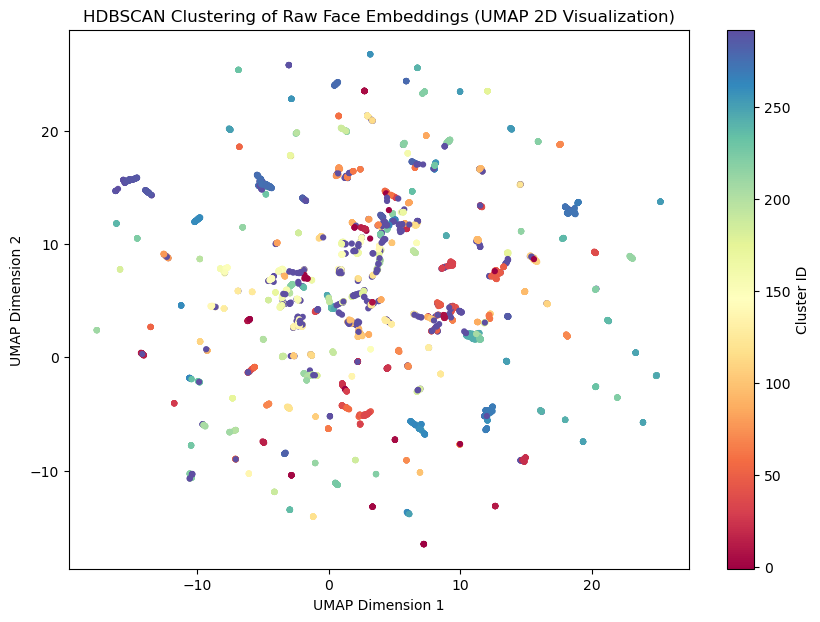

In [82]:
# Scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_vis[:, 0], X_vis[:, 1], 
            c=df["cluster_id"], cmap="Spectral", s=12)
plt.title("HDBSCAN Clustering of Raw Face Embeddings (UMAP 2D Visualization)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster ID")
plt.show()

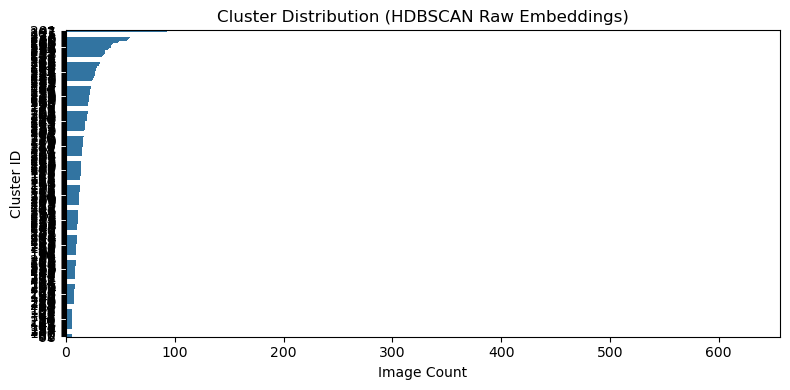

In [83]:
# Bar chart of cluster distribution
plt.figure(figsize=(8, 4))
sns.countplot(y=df["cluster_id"], order=df["cluster_id"].value_counts().index)
plt.title("Cluster Distribution (HDBSCAN Raw Embeddings)")
plt.xlabel("Image Count")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()


In [84]:
# --- Compute centroids per cluster (excluding -1) ---
cluster_centroids = (
    df[df["cluster_id"] != -1]
    .groupby("cluster_id")["embedding"]
    .apply(lambda x: np.mean(np.vstack(x.values), axis=0))
    .reset_index()
)
cluster_centroids.columns = ["cluster_id", "centroid"]

# --- Compute cluster sizes ---
cluster_sizes = df[df["cluster_id"] != -1]["cluster_id"].value_counts().to_dict()
avg_cluster_size = np.mean(list(cluster_sizes.values()))

print(f"📊 Average cluster size: {avg_cluster_size:.2f}")

📊 Average cluster size: 18.85


In [85]:
# --- Compute centroid similarity ---
from sklearn.metrics.pairwise import cosine_similarity
# --- Compute centroid similarity ---
centroid_matrix = np.vstack(cluster_centroids["centroid"].values)
sim_matrix = cosine_similarity(centroid_matrix)

In [86]:
import networkx as nx
threshold = 0.85

G = nx.Graph()

for i, cid1 in enumerate(cluster_centroids["cluster_id"]):
    for j, cid2 in enumerate(cluster_centroids["cluster_id"]):
        if i < j and sim_matrix[i, j] >= threshold:
            size1, size2 = cluster_sizes.get(cid1, 0), cluster_sizes.get(cid2, 0)
            # ✅ Only merge if both clusters are smaller than average
            if size1 <= avg_cluster_size and size2 <= avg_cluster_size:
                G.add_edge(cid1, cid2)

# --- Find merged cluster groups ---
merged_groups = list(nx.connected_components(G))
print(f"\n🔗 Found {len(merged_groups)} potential merge groups (only small clusters).")


🔗 Found 30 potential merge groups (only small clusters).


In [87]:
merged_groups

[{2, 3},
 {4, 5},
 {9, 10},
 {18, 21, 22, 292},
 {26, 42, 43},
 {30, 45, 51, 52, 53},
 {36, 49, 50},
 {64, 65},
 {98, 99},
 {109, 110},
 {112, 113},
 {114, 119, 121, 124, 125, 126},
 {131, 136, 139, 140},
 {132, 133},
 {145, 154, 155},
 {147, 148},
 {149, 152, 157, 158},
 {185, 200, 223, 233, 259},
 {187, 197, 222},
 {192, 245, 246, 251},
 {195, 196},
 {201, 205, 211},
 {204, 207, 208},
 {206, 244},
 {209, 214},
 {232, 241, 242, 247},
 {235, 239},
 {252, 253, 287, 289, 290},
 {256, 257},
 {278, 281}]

In [88]:
merge_map = {}
for group in merged_groups:
    group = list(group)
    if len(group) > 1:
        base = group[0]  # use the first as base cluster
        for cid in group[1:]:
            merge_map[cid] = base

# --- Apply merge mapping ---
df["cluster_id"] = df["cluster_id"].replace(merge_map)

print(f"✅ Applied {len(merge_map)} cluster merges (excluding noise).")
print(f"🧩 Unique clusters remaining after merge: {df['cluster_id'].nunique()}")
print(df["cluster_id"].value_counts().head())


✅ Applied 59 cluster merges (excluding noise).
🧩 Unique clusters remaining after merge: 235
cluster_id
291    625
47      93
107     88
221     83
114     82
Name: count, dtype: int64


In [89]:
# EXPORT CLUSTERED IMAGES (INCLUDING NOISE)
# ============================================================

SOURCE_DIR = Path("../data/crops_face/20251107/3_cafe_pos_frontal_faces")
OUTPUT_DIR = Path("../data/crops_face/20251107/4_cafe_pos_cluster_faces")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

cluster_ids = sorted(df["cluster_id"].unique())
print(f"💾 Saving {len(cluster_ids)} clusters (including noise)...")

for cluster_id in tqdm(cluster_ids, desc="Exporting clusters"):
    if cluster_id == -1:
        cluster_folder = OUTPUT_DIR / "cluster_noise"
    else:
        cluster_folder = OUTPUT_DIR / f"cluster_{int(cluster_id):03d}"
    cluster_folder.mkdir(exist_ok=True)
    
    cluster_files = df[df["cluster_id"] == cluster_id]["file"].values
    for file_name in cluster_files:
        src_path = SOURCE_DIR / file_name
        dst_path = cluster_folder / file_name
        if src_path.exists():
            shutil.copy2(src_path, dst_path)

print(f"✅ Export complete → {OUTPUT_DIR}")

💾 Saving 235 clusters (including noise)...


Exporting clusters: 100%|██████████| 235/235 [00:19<00:00, 11.79it/s]

✅ Export complete → ..\data\crops_face\20251107\4_cafe_pos_cluster_faces


In [90]:
# '''
# Column	Meaning
# metric:	            Distance metric used for clustering
# min_cluster_size:	Minimum cluster population
# min_samples:	    Minimum core points for density
# epsilon:        	Tolerance for merging adjacent clusters
# selection	        HDBSCAN cluster selection strategy (eom = more stable, leaf = finer splits)
# clusters	        Number of clusters found
# noise_%	            Percentage of unclustered (outlier) points
# avg_cluster_size	Mean cluster population
# silhouette	        Cluster separation quality
# mean_intra_dist	    Average internal cluster compactness (lower = tighter)
# score	            Combined heuristic ranking score
# '''

In [91]:
# import hdbscan
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import normalize
# from sklearn.metrics import silhouette_score, pairwise_distances
# from tqdm import tqdm

# # === Prepare normalized embeddings ===
# X = np.vstack(df["embedding"].values)
# X_norm = normalize(X)

# # === Parameter grid ===
# param_grid = {
#     "metric": ["cosine"], #,"euclidean"
#     "min_cluster_size": [7],
#     "min_samples": [1, 2, 3, 4, 5],
#     "cluster_selection_epsilon": [0,0.05,0.1,0.2,0.25,0.3],
#     "cluster_selection_method": ["leaf", "eom"] 
# }

# results = []

# print("🔍 Running unbiased HDBSCAN parameter tuning...\n")

# for metric in param_grid["metric"]:
#     for min_cluster_size in param_grid["min_cluster_size"]:
#         for min_samples in param_grid["min_samples"]:
#             for epsilon in param_grid["cluster_selection_epsilon"]:
#                 for selection_method in param_grid["cluster_selection_method"]:

#                     try:
#                         # Handle cosine manually
#                         if metric == "cosine":
#                             dist_matrix = pairwise_distances(X_norm, metric="cosine")
#                             clusterer = hdbscan.HDBSCAN(
#                                 metric="precomputed",
#                                 min_cluster_size=min_cluster_size,
#                                 min_samples=min_samples,
#                                 cluster_selection_epsilon=epsilon,
#                                 cluster_selection_method=selection_method
#                             ).fit(dist_matrix)
#                         else:
#                             clusterer = hdbscan.HDBSCAN(
#                                 metric=metric,
#                                 min_cluster_size=min_cluster_size,
#                                 min_samples=min_samples,
#                                 cluster_selection_epsilon=epsilon,
#                                 cluster_selection_method=selection_method
#                             ).fit(X_norm)

#                         labels = clusterer.labels_
#                         n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#                         noise_points = list(labels).count(-1)
#                         noise_ratio = noise_points / len(labels) * 100

#                         # Skip completely failed clusterings
#                         if n_clusters == 0:
#                             continue

#                         # Average cluster size
#                         avg_cluster_size = (
#                             pd.Series(labels).value_counts()[pd.Series(labels).value_counts().index != -1].mean()
#                         )

#                         # Mean intra-cluster distance
#                         intra_dists = []
#                         for cid in set(labels):
#                             if cid == -1:
#                                 continue
#                             cluster_points = X_norm[np.array(labels) == cid]
#                             if len(cluster_points) > 1:
#                                 dists = pairwise_distances(cluster_points, metric=metric)
#                                 intra_dists.append(np.mean(dists))
#                         mean_intra_cluster_dist = np.mean(intra_dists) if intra_dists else np.nan

#                         # Silhouette score
#                         try:
#                             sil_score = silhouette_score(X_norm, labels) if n_clusters > 1 else np.nan
#                         except Exception:
#                             sil_score = np.nan

#                         # Composite heuristic (unbiased)
#                         heuristic_score = (
#                             (1 - noise_ratio / 100) *
#                             (sil_score if not np.isnan(sil_score) else 0.01) *
#                             (1 / (1 + mean_intra_cluster_dist if not np.isnan(mean_intra_cluster_dist) else 1))
#                         )

#                         results.append({
#                             "metric": metric,
#                             "min_cluster_size": min_cluster_size,
#                             "min_samples": min_samples,
#                             "epsilon": epsilon,
#                             "selection": selection_method,
#                             "clusters": n_clusters,
#                             "noise_%": round(noise_ratio, 2),
#                             "avg_cluster_size": round(avg_cluster_size, 2),
#                             "silhouette": round(sil_score, 3),
#                             "mean_intra_dist": round(mean_intra_cluster_dist, 4),
#                             "score": round(heuristic_score, 6)
#                         })

#                     except Exception as e:
#                         print(f"⚠️ Skipped {metric}, mcs={min_cluster_size}, ms={min_samples}, eps={epsilon}: {e}")
#                         continue

# # === Rank and inspect results ===
# results_df = pd.DataFrame(results).sort_values(by="score", ascending=False).reset_index(drop=True)
# print("✅ Parameter tuning complete!\n")
# display(results_df.head(10))


In [92]:
# results_df.to_csv("../data/crops_face/4_facial_embeddings/hdbscan_parameter_tuning_cafe_pos_cosine_3.csv", index=False)